In [1]:
import keplergl
from src.settings import DATA_RAW_DIR
from src.data.download import get_bounding_gdf
from pathlib import Path
from src.data.load_data import load_city_tag
from src.data.make_dataset import add_h3_indices
import pandas as pd
import geopandas as gpd
from src.data.utils import TOP_LEVEL_OSM_TAGS
from src.settings import DATA_INTERIM_DIR
from pathlib import Path
from src.data.make_dataset import group_city_tags
from src.data.make_dataset import add_h3_indices_to_city, merge_all_tags_for_city, group_city_top_level_tags
from src.visualization.visualize import visualize_kepler
import plotly.express as px
from src.visualization.config import save_config
from src.visualization.visualize import visualize_df
from src.models.clustering import Clusterizer, TfidfEmbedder, NormalizingEmbedder
from sklearn.cluster import KMeans
import umap
import plotly.express as px
from src.data.make_dataset import get_hexes_polygons_for_city
from src.visualization.visualize import visualize_kepler, visualize_df
from src.visualization.visualize import visualize_dendrogram
from src.data.make_dataset import group_city_tags
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import plotly.express as px
from src.models.clustering import Clusterizer, NormalizingEmbedder, TfidfEmbedder
from sklearn.cluster import KMeans
from src.data.load_data import load_processed_dataset
from src.models.autoencoder import LitAutoEncoder
from src.models.clustering import NormalizingEmbedder
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch

In [2]:
from pytorch_lightning.utilities.seed import seed_everything
SEED = 42
seed_everything(SEED)

Global seed set to 42


42

In [3]:
from src import settings
settings.DATA_DIR = Path("/Users/max/Desktop/osmnx-cities")
settings.DATA_RAW_DIR = settings.DATA_DIR.joinpath("raw")
settings.DATA_INTERIM_DIR = settings.DATA_DIR.joinpath("interim")
settings.DATA_PROCESSED_DIR = settings.DATA_DIR.joinpath("processed")

In [4]:
SELECTED_TAGS = [
    "aeroway",
    "amenity",
    "building",
    "healthcare",
    "historic",
    "landuse",
    "leisure",
    "military",
    "natural",
    "office",
    "shop",
    "sport",
    "tourism",
    "water",
    "waterway"
]

In [5]:
RESOLUTION = 9

In [6]:
df = load_processed_dataset(RESOLUTION, select_tags=SELECTED_TAGS, data_dir=settings.DATA_PROCESSED_DIR)

In [7]:
problem_columns = [
    'amenity_waste_basket',
    'landuse_grass',
    'historic_tomb',
    'natural_tree',
    'natural_tree_row',
    'natural_valley', # northern Warsaw
]

In [8]:
num_in_cities = (df.groupby('city').sum() > 0).sum()
columns_cities_less_than_3 = df.columns.drop('city')[(df.groupby('city').sum() > 0).sum() < 3]

In [9]:
df = load_processed_dataset(RESOLUTION, select_tags=SELECTED_TAGS, data_dir=settings.DATA_PROCESSED_DIR)
df = df.drop(columns=problem_columns)
zero_cities_columns = df.columns.drop('city')[(df.groupby('city').sum() > 0).sum() == 0]
df = df.drop(columns=zero_cities_columns)
df = df[~(df.drop(columns='city') == 0).all(axis=1)]
df

,aeroway_aerodrome,aeroway_apron,aeroway_hangar,aeroway_helipad,aeroway_navigationaid,aeroway_runway,aeroway_taxiway,aeroway_terminal,aeroway_gate,aeroway_heliport,...,waterway_dock,waterway_drain,waterway_lock_gate,waterway_stream,waterway_waterfall,waterway_river,waterway_pressurised,waterway_weir,waterway_fuel,city
h3,,,,,,,,,,,,,,,,,,,,,
8928d540003ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Seattle, USA"
8928d540007ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Seattle, USA"
8928d54000bffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Seattle, USA"
8928d54000fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Seattle, USA"
8928d540013ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Seattle, USA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89489eaeb67ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"Austin, USA"
89489eaeb6bffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Austin, USA"
89489eaeb6fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Austin, USA"


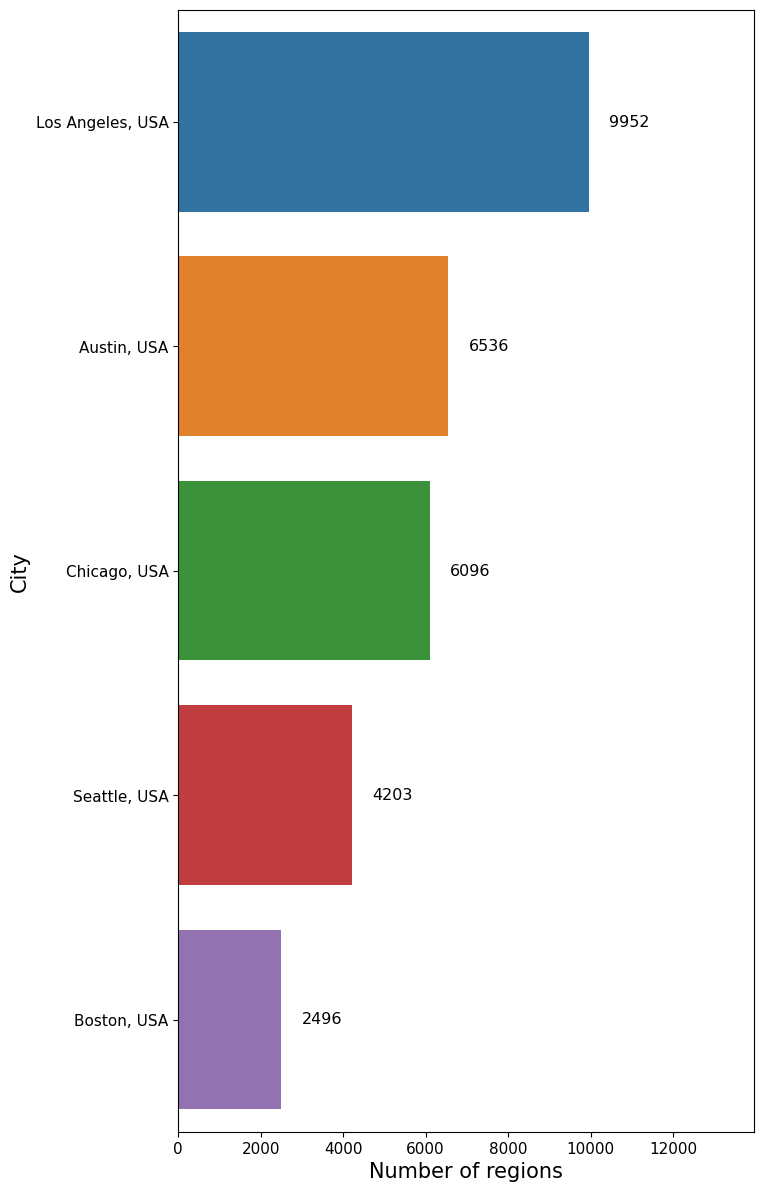

In [10]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,12))
sns.set_context("paper", font_scale=1.2)
counts = df.groupby('city').size().to_frame().reset_index().rename(columns={"city": "City", 0: "Number of regions"}).sort_values("Number of regions", ascending=False)
counts['City'] = counts['City'].str.replace("PL", "Poland")
g = sns.barplot(data=counts, y="City", x="Number of regions", orient='h', ax=ax)
# sns.barplot(.sort_values(ascending=False).to_frame())
for index, row in counts.iterrows():
    g.text(row['Number of regions'] + 500, counts.index.get_loc(counts[counts['City'] == row.City].index[0]), row["Number of regions"], color='black', va="center", ha="left")
plt.tight_layout()
plt.xlim(0, counts['Number of regions'].max() + 4000)
g.set_xlabel(g.get_xlabel(), fontsize=15)
g.set_ylabel(g.get_ylabel(), fontsize=15)
g.tick_params(labelsize=11)
plt.savefig("city_counts.png")

In [11]:
df.groupby('city').size().sort_values(ascending=False)

city
Los Angeles, USA    9952
Austin, USA         6536
Chicago, USA        6096
Seattle, USA        4203
Boston, USA         2496
dtype: int64

In [12]:
df_cols = pd.read_csv("w2v_columns.csv")
df_cols = df_cols.drop(df_cols[df_cols['column'] == 'city'].index)

In [13]:
split = df_cols.column.str.split("_", 1)
df_cols['key'] = split.str[0]
df_cols['value'] = split.str[1]

used_vals = dict(df_cols[['key', 'value']].groupby('key')['value'].apply(set))

In [14]:
df_cols

,column,key,value
0,aeroway_aerodrome,aeroway,aerodrome
1,aeroway_apron,aeroway,apron
2,aeroway_hangar,aeroway,hangar
3,aeroway_helipad,aeroway,helipad
4,aeroway_navigationaid,aeroway,navigationaid
...,...,...,...
599,waterway_waterfall,waterway,waterfall
600,waterway_river,waterway,river
601,waterway_pressurised,waterway,pressurised
602,waterway_weir,waterway,weir


In [15]:
df_cols[df_cols['column'] == 'amenity_kneipp_water_cure']

,column,key,value


In [16]:
from src.data.load_data import load_filter
import os
from_wiki = load_filter("from_wiki.json")

row = "\\TopicLine \\Topic[\\texttt{%s}] & \\texttt{%s} & %s \\\\\n"

rows = []
for key in sorted(from_wiki.keys()):
    vals = sorted(from_wiki[key])
    key_str = key.replace("_", "\\_")
    for val in vals:
        val_str = val.replace("_", "\\_")
        if key in SELECTED_TAGS and val in used_vals[key]:
            rows.append(row%(key_str, val_str, "\\checkmark"))
        else:
            rows.append(row%(key_str, val_str, ""))
with open("tags.txt", 'wt') as f:
    f.writelines(rows)

In [17]:
df.columns.to_series(name="column").to_csv("w2v_columns.csv", index=False)

In [18]:
train_df = df

In [19]:
from src.models.h3_neighbor_dataset import H3NeighborDataset

In [20]:
train_dataset = H3NeighborDataset(train_df.drop(columns='city'))

100%|██████████| 29283/29283 [00:00<00:00, 31045.45it/s]


In [21]:
from torch.utils.data import TensorDataset, DataLoader
from src.models.binary_nn import BinaryNN
import torch
from pytorch_lightning.loggers.wandb import WandbLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LambdaCallback

In [24]:
from torch.utils.data import TensorDataset, DataLoader
from src.models.binary_nn import BinaryNN
import torch
from pytorch_lightning.loggers.wandb import WandbLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LambdaCallback

data_shape = train_dataset.data.shape[1]

batch_size = 512
epochs = 100

sizes = [150, 75, 50]

logger = WandbLogger(project="test-project", entity="green-last-mile")
trainer = pl.Trainer(max_epochs=epochs, logger=logger, )
model = BinaryNN([data_shape, *sizes])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/max/.pyenv/versions/3.9.10/envs/hex2vec/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [25]:
import wandb 
run = wandb.init(reinit=True, name=f"f1_w2v_s_{sizes};b_{batch_size};ep_{epochs}")
trainer.fit(model, train_dataloader)
run.finish()

/Users/max/.pyenv/versions/3.9.10/envs/hex2vec/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 105 K 
---------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.423     Total estimated model params size (MB)
/Users/max/.pyenv/versions/3.9.10/envs/hex2vec/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/Users/max/.pyenv/versions/3.9.10/envs/hex2vec/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/max/.pyenv/versions/3.9.10/envs/hex2vec/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 512. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/Users/max/.pyenv/versions/3.9.10/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/Users/max/.pyenv/versions/3.9.10/envs/hex2vec/lib/python3.9/site-packages/wandb/sdk/service/server_sock.py", line 113, in run
    shandler(sreq)
  File "/Users/max/.pyenv/versions/3.9.10/envs/hex2vec/lib/python3.9/site-pack

wandb: ERROR Control-C detected -- Run data was not synced


In [121]:
embedded = model.encoder(torch.Tensor(train_df.drop(columns='city').to_numpy())).detach().numpy()

In [122]:
embedded.shape

(183961, 50)

In [123]:
model.encoder

Sequential(
  (0): Linear(in_features=725, out_features=150, bias=True)
  (1): ReLU()
  (2): Linear(in_features=150, out_features=75, bias=True)
  (3): ReLU()
  (4): Linear(in_features=75, out_features=50, bias=True)
)

In [124]:
import numpy as np
polish_cities = train_df.city.str.endswith("PL")

whole_df = train_df[polish_cities]
whole_df.shape

(21392, 726)

In [125]:
embedded_df = pd.DataFrame(embedded[polish_cities])
embedded_df = embedded_df.set_index(whole_df.index)
embedded_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
h3,,,,,,,,,,,,,,,,,,,,,
891f52240a7ffff,0.067662,0.107057,0.447783,-0.171524,-0.356142,0.257898,-0.597308,0.151033,0.809325,0.430609,...,-0.786128,-0.268614,-0.164809,0.046405,0.350349,0.704287,0.012877,-0.054195,0.146384,0.782191
891f52240b3ffff,0.853464,0.327113,0.156100,-0.238570,-0.045227,-0.206263,0.186677,-0.164316,-0.060736,-0.328115,...,0.070138,0.082066,-0.237396,-0.181171,0.055429,-0.156340,0.173047,0.127445,-0.096901,-0.389923
891f52240b7ffff,0.424311,0.450197,0.420848,0.139138,-0.014721,-0.135146,-0.192939,0.075444,1.052082,-0.176548,...,-0.709417,-0.304113,0.036142,-0.204111,0.175267,0.006256,-0.300998,0.648282,-0.107926,0.100051
891f5224103ffff,-0.521108,-0.141568,0.177161,0.080389,-0.306628,0.495450,-0.750612,-0.030208,0.820112,0.418797,...,-0.415995,-0.065345,-0.259769,-0.515772,-0.251049,0.318462,-0.191477,0.277968,0.406461,0.482841
891f5224107ffff,0.145667,0.383897,-0.278015,-0.154838,-0.091935,0.383703,-0.271918,-0.016493,0.491969,0.492741,...,0.025050,-0.828537,0.888401,-0.509302,0.094636,0.308518,-0.022681,0.033891,0.604063,0.135768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f724f343ffff,0.056657,0.291592,0.530118,0.299336,0.175177,-0.216328,-0.142380,-0.078727,-0.500076,0.218576,...,0.224867,-0.138311,-0.352070,0.031226,-0.029624,0.489021,0.466707,0.306672,0.234649,0.197462
891f724f34bffff,-0.063064,0.482642,0.482640,0.097365,-0.016143,-0.219976,-0.181672,-0.008008,-0.326970,0.199914,...,0.347694,-0.083707,-0.399994,0.019886,0.052547,0.409024,0.496076,0.372077,0.227190,0.253646
891f724f34fffff,0.056657,0.291592,0.530118,0.299336,0.175177,-0.216328,-0.142380,-0.078727,-0.500076,0.218576,...,0.224867,-0.138311,-0.352070,0.031226,-0.029624,0.489021,0.466707,0.306672,0.234649,0.197462


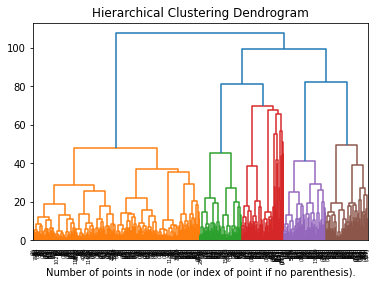

In [126]:
cluster_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
cluster_model.fit(embedded_df)
plt.title('Hierarchical Clustering Dendrogram')
visualize_dendrogram(cluster_model, truncate_mode='level', p=8)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
trainer.save_checkpoint("w2v_final.ckpt")

In [127]:
cluster_model = AgglomerativeClustering(n_clusters=8, linkage='ward')
labels = cluster_model.fit_predict(embedded_df)
result_df = whole_df.copy(deep=False)
result_df['label'] = labels
result_df['label'] = result_df['label'].astype(str)
result_df.columns = result_df.columns.astype(str)

In [128]:
m = visualize_kepler(result_df.reset_index(), config_name="agglomerative_8_no_preprocessing")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'f0myb4', 'type': '…

In [34]:
def cluster_difference(df, first_cluster, second_cluster):
    means = df.groupby('label').mean()
    return (means.loc[first_cluster] - means.loc[second_cluster]).sort_values(ascending=False)

def explain_cluster(df, cluster):
    return df.groupby('label').mean().loc[cluster].sort_values(ascending=False)

In [137]:
result_df.loc['891f7248233ffff'].drop(['city', 'label']).sort_values()

aeroway_apron               0.0
shop_interior_decoration    0.0
shop_jewelry                0.0
shop_kiosk                  0.0
shop_kitchen                0.0
                           ... 
historic_charcoal_pile      0.0
historic_church             0.0
historic_ruins              0.0
waterway_water_point        0.0
landuse_forest              1.0
Name: 891f7248233ffff, Length: 725, dtype: object

In [113]:
cluster_model = AgglomerativeClustering(n_clusters=10, linkage='ward')
labels = cluster_model.fit_predict(embedded_df)
result_df = whole_df.copy(deep=False)
result_df['label'] = labels
result_df['label'] = result_df['label'].astype(str)
result_df.columns = result_df.columns.astype(str)

In [114]:
m = visualize_kepler(result_df.reset_index(), config_name="agglomerative_8_no_preprocessing")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'f0myb4', 'type': '…

In [123]:
cluster_model = AgglomerativeClustering(n_clusters=11, linkage='ward')
labels = cluster_model.fit_predict(embedded_df)
result_df = whole_df.copy(deep=False)
result_df['label'] = labels
result_df.columns = result_df.columns.astype(str)

In [124]:
result_df.label.unique()

array([ 3,  0,  2,  9,  4, 10,  7,  5,  1,  8,  6], dtype=int64)

In [125]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [126]:
m = visualize_kepler(result_df.reset_index(), config_name="agglomerative_8_no_preprocessing")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'f0myb4', 'type': '…

In [46]:
def cluster_difference(df, first_cluster, second_cluster):
    means = df.groupby('label').mean()
    return (means.loc[first_cluster] - means.loc[second_cluster]).sort_values(ascending=False)

In [49]:
whole_df['label'] = result_df['label']
cluster_difference(whole_df, '0', '1')

<ipython-input-49-57aabdb6717e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whole_df['label'] = result_df['label']


building_yes              19.590161
building_house             1.278655
building_detached          0.985905
amenity_parking            0.891247
building_residential       0.702369
                           ...     
natural_grassland         -1.434518
landuse_commercial        -1.853680
building_hotel            -1.986728
building_apartments      -13.648843
historic_tomb          -1424.954206
Length: 752, dtype: float64

In [128]:
cluster_model = AgglomerativeClustering(n_clusters=12, linkage='ward')
labels = cluster_model.fit_predict(embedded_df)
result_df = whole_df.copy(deep=False)
result_df['label'] = labels
result_df.columns = result_df.columns.astype(str)

In [129]:
m = visualize_kepler(result_df.reset_index(), config_name="agglomerative_8_no_preprocessing")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'f0myb4', 'type': '…

In [130]:
cluster_model = AgglomerativeClustering(n_clusters=13, linkage='ward')
labels = cluster_model.fit_predict(embedded_df)
result_df = whole_df.copy(deep=False)
result_df['label'] = labels
result_df.columns = result_df.columns.astype(str)

In [131]:
m = visualize_kepler(result_df.reset_index(), config_name="agglomerative_8_no_preprocessing")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'f0myb4', 'type': '…

In [132]:
cluster_model = AgglomerativeClustering(n_clusters=15, linkage='ward')
labels = cluster_model.fit_predict(embedded_df)
result_df = whole_df.copy(deep=False)
result_df['label'] = labels
result_df.columns = result_df.columns.astype(str)

In [133]:
m = visualize_kepler(result_df.reset_index(), config_name="agglomerative_8_no_preprocessing")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'f0myb4', 'type': '…

In [135]:
cluster_model = AgglomerativeClustering(n_clusters=20, linkage='ward')
labels = cluster_model.fit_predict(embedded_df)
result_df = whole_df.copy(deep=False)
result_df['label'] = labels
result_df.columns = result_df.columns.astype(str)

In [136]:
m = visualize_kepler(result_df.reset_index(), config_name="agglomerative_8_no_preprocessing")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'f0myb4', 'type': '…

In [138]:
torch.save(model.state_dict(), "model.pt")

In [141]:
model = BinaryNN([data_shape, *sizes])

In [142]:
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [144]:
(model.encoder(torch.Tensor(train_df.drop(columns='city').to_numpy())).detach().numpy() == embedded).mean()

1.0

In [8]:
from src.models.binary_nn import BinaryNN
model = BinaryNN.load_from_checkpoint("w2v_final.ckpt", encoder_sizes=[725, 150, 75, 50])

In [150]:
import pickle as pkl
with open("no_wroclaw_embeddings.pkl", "wb") as f:
    pkl.dump(embedded, f)

In [21]:
import pickle as pkl
with open("no_wroclaw_embeddings.pkl", "rb") as f:
    embedding = pkl.load(f)

In [13]:
embedding = model.encoder(torch.Tensor(train_df.drop(columns='city').to_numpy())).detach().numpy()

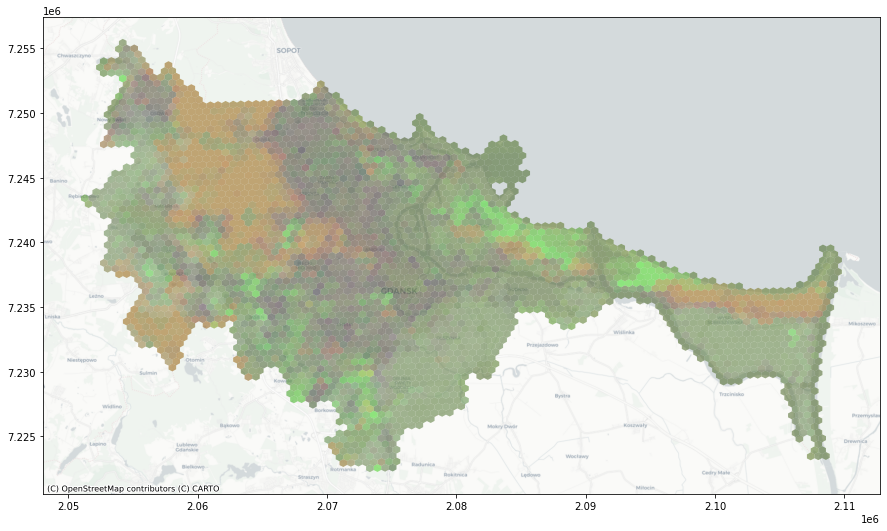

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import contextily as ctx
from src.data.make_dataset import h3_to_polygon

pca_embeddings = PCA(3).fit_transform(embedding)
rgb = MinMaxScaler().fit_transform(pca_embeddings)

fig_size=(15, 15)
map_source=ctx.providers.CartoDB.Positron

warszawa_regions = train_df.city.str.endswith("Gdańsk, PL")
warszawa_df = df[warszawa_regions]
warszawa_colors = rgb[warszawa_regions]

warszawa_df = warszawa_df.copy(deep=False)
warszawa_df['geometry'] = warszawa_df.index.map(h3_to_polygon)
warszawa_df = gpd.GeoDataFrame(warszawa_df, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=fig_size)
warszawa_df.to_crs(epsg=3857).plot(ax=ax, alpha=0.6, legend=True, color=warszawa_colors)
ctx.add_basemap(ax, source=map_source)

In [33]:
import spectra
import numpy as np
lch = rgb * np.array([100, 100, 360])

In [37]:
rgb2 = np.array([np.array(spectra.lch(*row).to("rgb").rgb) for row in lch])

In [44]:
rgb2 = np.clip(rgb2, 0, 1)

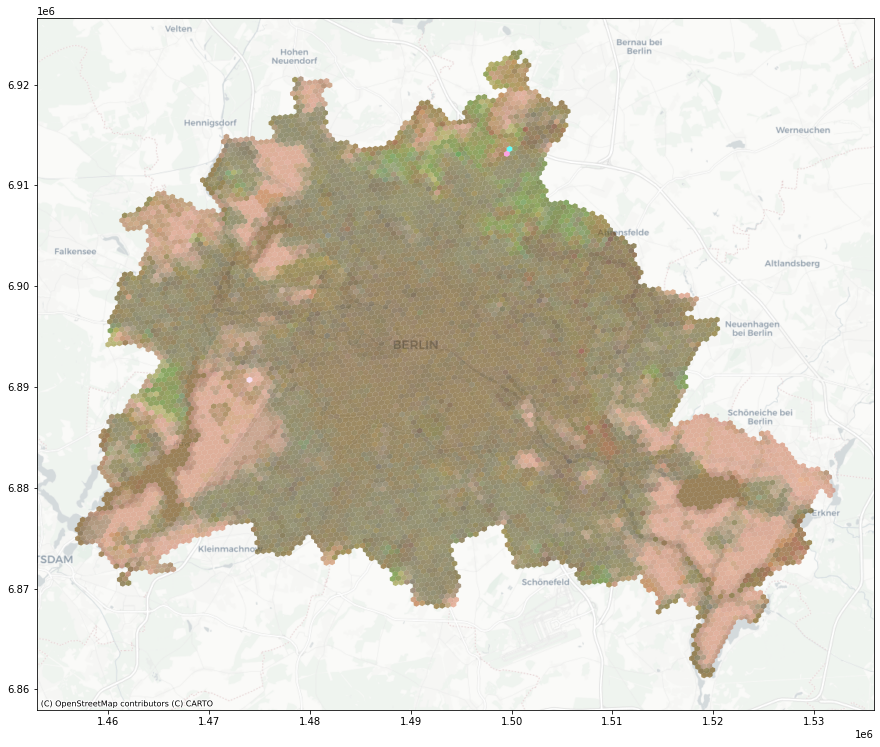

In [45]:
warszawa_regions = train_df.city.str.endswith("Berlin, Germany")
warszawa_df = df[warszawa_regions]
warszawa_colors = rgb2[warszawa_regions]

warszawa_df = warszawa_df.copy(deep=False)
warszawa_df['geometry'] = warszawa_df.index.map(h3_to_polygon)
warszawa_df = gpd.GeoDataFrame(warszawa_df, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=fig_size)
warszawa_df.to_crs(epsg=3857).plot(ax=ax, alpha=0.6, legend=True, color=warszawa_colors)
ctx.add_basemap(ax, source=map_source)

In [21]:
keplergl.KeplerGl(data={"a": warszawa_df})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'a':                  aeroway_apron  aeroway_helipad  aeroway_heliport  \
h3                   …

In [30]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
park_embedding = embedding[train_df.index.get_loc("891e2045487ffff")].reshape(1, -1)

similarities = cosine_similarity(embedding, park_embedding)
train_df['sim'] = similarities

In [ ]:
polish_cities = train_df.city.str.endswith("PL")

polish_df = train_df[polish_cities]
keplergl.KeplerGl(data={"polish": polish_df.reset_index()}, height=800)

from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
from sklearn.model_selection import train_test_split

embed_train, embed_test = train_test_split(train_size=0.2)
tsne = UMAP()
small = tsne.fit_transform(embedding)

In [18]:
def to_continent(country):
    if country.endswith("USA"):
        return "America"
    else:
        return "Europe"
train_df['continent'] = train_df['city'].apply(to_continent)

<AxesSubplot:>

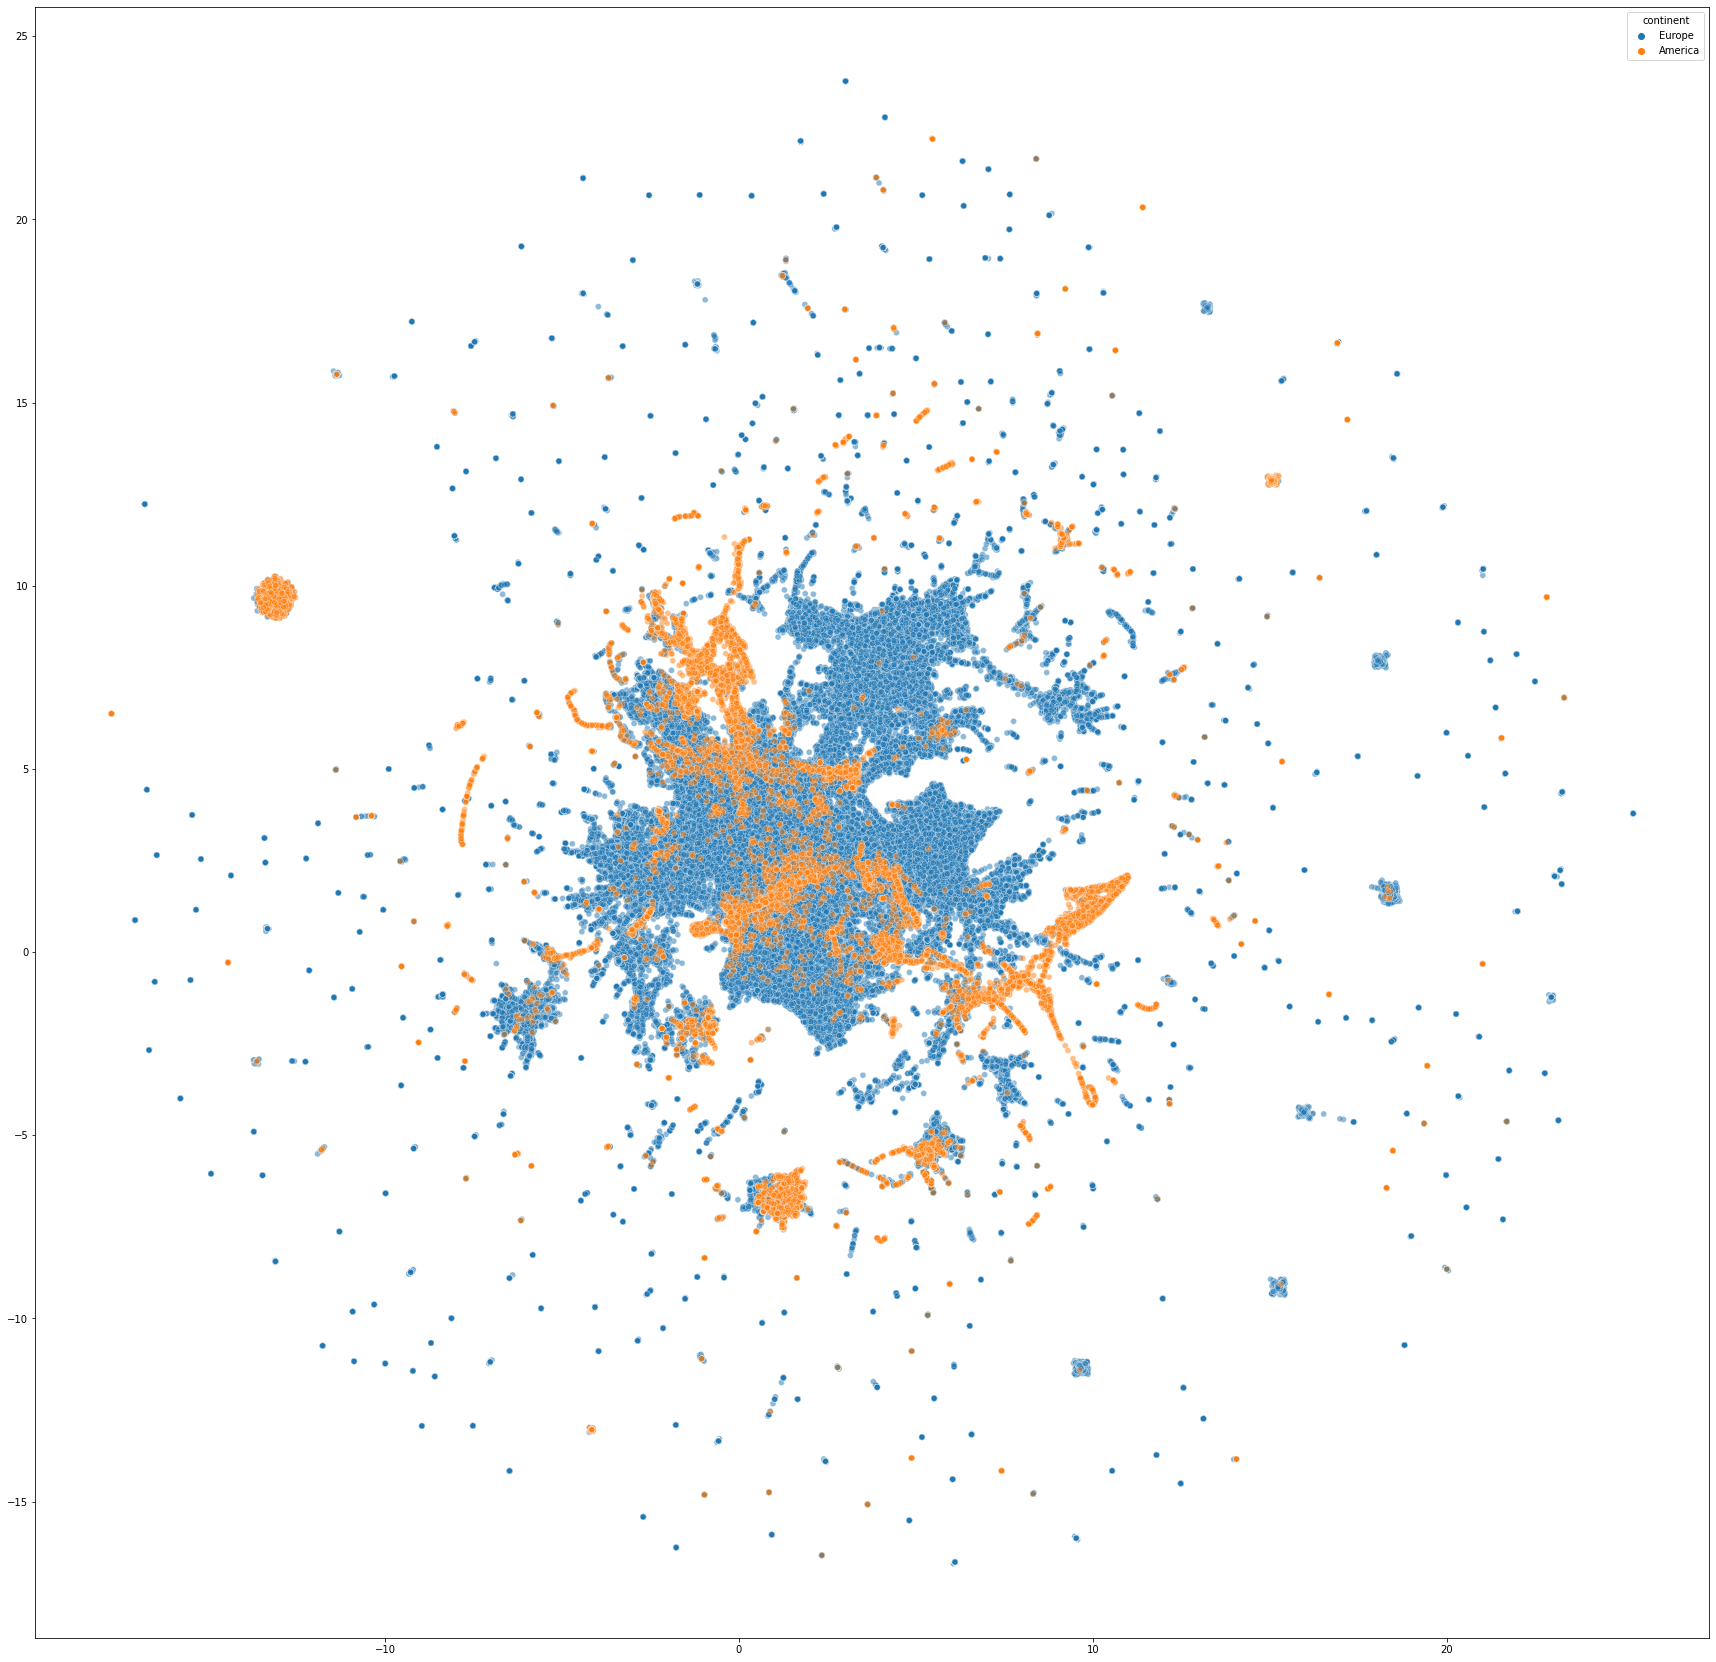

In [30]:
fig, ax = plt.subplots(figsize=(30,30))
sns.scatterplot(x=small[:, 0], y=small[:, 1], hue=train_df.continent, ax=ax, alpha=0.5)

In [194]:
keplergl.KeplerGl(data={"a": train_df[train_df.city == 'New York City, USA'].reset_index()})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'a':                     h3  aeroway_apron  aeroway_helipad  aeroway_heliport  \
0      892a100…

In [35]:
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 8)
df[df['aeroway_taxiway'] != 0]

,aeroway_apron,aeroway_helipad,aeroway_heliport,...,waterway_turning_point,waterway_water_point,city
h3,,,,,,,
891e15b5457ffff,1.0,0.0,1.0,...,0.0,0.0,"Vienna, Austria"
891e15b54cfffff,0.0,1.0,1.0,...,0.0,0.0,"Vienna, Austria"
891f4eaa027ffff,0.0,11.0,0.0,...,0.0,0.0,"Minsk, Belarus"
891f4eaa02fffff,0.0,1.0,0.0,...,0.0,0.0,"Minsk, Belarus"
...,...,...,...,...,...,...,...
89275935dbbffff,0.0,0.0,0.0,...,0.0,0.0,"Chicago, USA"
89275935dc7ffff,0.0,0.0,0.0,...,0.0,0.0,"Chicago, USA"
89275935dd3ffff,1.0,0.0,0.0,...,0.0,0.0,"Chicago, USA"
89275935dd7ffff,1.0,0.0,0.0,...,0.0,0.0,"Chicago, USA"


In [24]:
beach_h3 = "891f724aa77ffff"
warsaw_h3 = '891f53c9017ffff'
warsaw2_h3 = '891f53c90abffff'

In [79]:
beach_h3 = "89283087633ffff"
center_h3 = "8928309584fffff"
between_h3 = "892a1060d0bffff"
from src.data.make_dataset import h3_to_polygon

# gpd.GeoDataFrame([h3_to_polygon(x) for x in [beach_h3, center_h3, between_h3]], columns=['geometry']).to_file("sum.geojson", "GeoJSON")

In [82]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
em_beach = embedding[train_df.index.get_loc(beach_h3)]
em_center = embedding[train_df.index.get_loc(center_h3)]

,h3,city
0,891f52240a7ffff,"Warszawa, PL"
1,891f52240b3ffff,"Warszawa, PL"
2,891f52240b7ffff,"Warszawa, PL"
3,891f5224103ffff,"Warszawa, PL"
4,891f5224107ffff,"Warszawa, PL"
...,...,...
21387,891f724f343ffff,"Gdańsk, PL"
21388,891f724f34bffff,"Gdańsk, PL"
21389,891f724f34fffff,"Gdańsk, PL"
21390,891f724f36bffff,"Gdańsk, PL"


In [182]:
keplergl.KeplerGl(data={"a": train_df[train_df['city'].str.endswith("PL")].reset_index()[['h3', 'city']]})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'a':                     h3          city
0      891f52240a7ffff  Warszawa, PL
1      891f52240…

In [ ]:
beach_h3 = "892a1018b37ffff"
center_h3 = "892a10010d7ffff"
em_beach = embedding[train_df.index.get_loc(beach_h3)]
em_center = embedding[train_df.index.get_loc(center_h3)]

import numpy as np
def interpolate_arrays(X1, X2, n_steps=20):
    """final function that interpolates arrays"""
    return np.linspace(X1, X2, n_steps)
steps = interpolate_arrays(em_beach, em_center)

hexes = []

for step in steps:
    similarities = cosine_similarity(embedding, step.reshape(1, -1))
    most_similar = similarities.squeeze().argsort()[::-1]
    similar_hex = train_df.iloc[most_similar[0]]
    hexes.append(similar_hex)

res = pd.concat(hexes, axis=1).T.reset_index()
res = res.drop_duplicates().reset_index(drop=True)
res['num'] = res.index
# # keplergl.KeplerGl(data ={"a": res})
num = 16
keplergl.KeplerGl(data ={"a": res.iloc[num].to_frame().T}, height=700)


In [245]:
res.iloc[num][res.iloc[num] != 0]

index                892a1005a83ffff
amenity_school                   1.0
building_yes                   491.0
city              New York City, USA
num                               16
Name: 16, dtype: object

In [196]:
res

,index,aeroway_apron,aeroway_helipad,aeroway_heliport,aeroway_taxiway,aeroway_windsock,aeroway_aerodrome,aeroway_gate,aeroway_hangar,aeroway_navigationaid,...,waterway_waterfall,waterway_weir,waterway_tidal_channel,waterway_pressurised,waterway_fairway,waterway_boatyard,waterway_turning_point,waterway_water_point,city,num
0,892a100ea6bffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"New York City, USA",0
1,8911aa61003ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Moscow, Russia",1
2,8911aa45033ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Moscow, Russia",2
3,8911aa01db7ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Moscow, Russia",3
4,8911aa6865bffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Moscow, Russia",4
5,8911aa4ed6fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Moscow, Russia",5
6,892a1077513ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"New York City, USA",6
7,892830953a7ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"San Francisco, USA",7
8,89283095cbbffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"San Francisco, USA",8
9,892a1060c9bffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"New York City, USA",9


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(train_df.drop(columns='city').to_numpy())

In [23]:
s = scaled[train_df.index.get_loc(beach_h3)] + scaled[train_df.index.get_loc(center_h3)]

In [24]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

similarities = cosine_similarity(scaled, s.reshape(1, -1))
most_similar = similarities.squeeze().argsort()[::-1]
hexes = train_df.index[most_similar[:50]]

In [29]:
train_df.loc[hexes]

,aeroway_apron,aeroway_helipad,aeroway_heliport,aeroway_taxiway,aeroway_windsock,aeroway_aerodrome,aeroway_gate,aeroway_hangar,aeroway_navigationaid,aeroway_runway,...,waterway_stream,waterway_waterfall,waterway_weir,waterway_tidal_channel,waterway_pressurised,waterway_fairway,waterway_boatyard,waterway_turning_point,waterway_water_point,city
h3,,,,,,,,,,,,,,,,,,,,,
8928309584fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"San Francisco, USA"
89283087633ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"San Francisco, USA"
89283087607ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"San Francisco, USA"
892830876afffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"San Francisco, USA"
892a10609dbffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"New York City, USA"
890999396c7ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Oslo, Norway"
89099939663ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Oslo, Norway"
890999396cbffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Oslo, Norway"
892830870d3ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"San Francisco, USA"


In [27]:
keplergl.KeplerGl(data={"a": pd.DataFrame(hexes[:15])})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'a':                  h3
0   8928309584fffff
1   89283087633ffff
2   89283087607ffff
3   892830…

In [89]:
keplergl.KeplerGl(data={"a": pd.DataFrame(train_df.loc[[beach_h3, center_h3]].reset_index())})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'a':                 h3  aeroway_apron  aeroway_helipad  aeroway_heliport  \
0  89283087633ffff…

In [53]:
train_df.iloc[train_df.index.get_loc(center_h3)].drop('city').sort_values(ascending=False).head(15)

building_yes               288.0
amenity_cafe                10.0
amenity_restaurant           9.0
shop_beauty                  5.0
amenity_bank                 5.0
shop_hairdresser             3.0
shop_mobile_phone            2.0
shop_greengrocer             2.0
healthcare_alternative       2.0
shop_convenience             2.0
amenity_bicycle_parking      2.0
amenity_dentist              2.0
amenity_bench                2.0
amenity_clinic               1.0
shop_laundry                 1.0
Name: 8928309584fffff, dtype: object

In [14]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
em_beach = embedding[train_df.index.get_loc(beach_h3)]
em_center = embedding[train_df.index.get_loc(center_h3)]
s = em_beach + em_center
similarities = cosine_similarity(embedding, s.reshape(1, -1))
most_similar = similarities.squeeze().argsort()[::-1]
hexes = train_df.index[most_similar[:50]]

In [15]:
keplergl.KeplerGl(data={"a": pd.DataFrame(hexes[:1])})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'a':                 h3
0  892a1060d0bffff})

In [64]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
em_beach = embedding[train_df.index.get_loc(beach_h3)]
em_center = embedding[train_df.index.get_loc(center_h3)]
similarities = pairwise_distances(embedding, em_beach.reshape(1, -1), metric='euclidean')
most_similar = similarities.squeeze().argsort()
hexes = train_df.index[most_similar[:100]]
train_df.loc[hexes].city.unique()

array(['San Francisco, USA', 'New York City, USA', 'Oslo, Norway',
       'Gdańsk, PL', 'Helsinki, Finland'], dtype=object)

In [56]:

keplergl.KeplerGl(data={"a": pd.DataFrame(hexes)})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'a':                  h3
0   891f53cb673ffff
1   891e1308b2fffff
2   891e2e6b3cbffff
3   89182c…

In [30]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
em_beach = embedding[train_df.index.get_loc(beach_h3)]
em_warsaw = embedding[train_df.index.get_loc(warsaw_h3)]
em_warsaw2 = embedding[train_df.index.get_loc(warsaw2_h3)]
s = em_beach + em_warsaw
cosine_similarity(em_beach.reshape(1, -1), em_warsaw.reshape(1, -1)), cosine_similarity(em_warsaw.reshape(1, -1), em_warsaw2.reshape(1, -1)), cosine_similarity(s.reshape(1, -1), em_warsaw.reshape(1, -1)), cosine_similarity(s.reshape(1, -1), em_beach.reshape(1, -1)), 

(array([[-0.10745344]], dtype=float32),
 array([[0.93782943]], dtype=float32),
 array([[0.7651836]], dtype=float32),
 array([[0.557863]], dtype=float32))

In [38]:
similarities = cosine_similarity(embedding, s.reshape(1, -1))
most_similar = similarities.squeeze().argsort()
hexes = train_df.index[most_similar[:50]]
keplergl.KeplerGl(data={"a": pd.DataFrame(hexes)})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'a':                  h3
0   891e8050bbbffff
1   8909993b1d7ffff
2   891e130f0bbffff
3   891e06…

In [40]:
train_df.loc[hexes]

,aeroway_apron,aeroway_helipad,aeroway_heliport,aeroway_taxiway,aeroway_windsock,aeroway_aerodrome,aeroway_gate,aeroway_hangar,aeroway_navigationaid,aeroway_runway,...,waterway_stream,waterway_waterfall,waterway_weir,waterway_tidal_channel,waterway_pressurised,waterway_fairway,waterway_boatyard,waterway_turning_point,waterway_water_point,city
h3,,,,,,,,,,,,,,,,,,,,,
891e8050bbbffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Rome, Italy"
8909993b1d7ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Oslo, Norway"
891e130f0bbffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Zagreb, Croatia"
891e0679223ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Vienna, Austria"
891e130c6bbffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Zagreb, Croatia"
89194e686c7ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"London, United Kingdom"
89195da755bffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"London, United Kingdom"
891e15b4c57ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Vienna, Austria"
891fa3cdc43ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Luxembourg City, Luxembourg"


In [19]:
import numpy as np
polish_cities = train_df.city.str.endswith("PL")
train_df[polish_cities]

polish_df = train_df[polish_cities].copy()
polish_df.shape
polish_embedding = pd.DataFrame(embedding[polish_cities])
polish_embedding = polish_embedding.set_index(polish_df.index)
polish_embedding

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
h3,,,,,,,,,,,,,,,,,,,,,
891f52240a7ffff,0.067662,0.107057,0.447783,-0.171524,-0.356142,0.257898,-0.597308,0.151033,0.809325,0.430609,...,-0.786128,-0.268614,-0.164809,0.046405,0.350349,0.704287,0.012877,-0.054195,0.146384,0.782191
891f52240b3ffff,0.853464,0.327113,0.156100,-0.238570,-0.045227,-0.206263,0.186677,-0.164316,-0.060736,-0.328115,...,0.070138,0.082066,-0.237396,-0.181171,0.055429,-0.156340,0.173047,0.127445,-0.096901,-0.389923
891f52240b7ffff,0.424311,0.450197,0.420848,0.139138,-0.014721,-0.135146,-0.192939,0.075444,1.052082,-0.176548,...,-0.709417,-0.304113,0.036142,-0.204111,0.175267,0.006256,-0.300998,0.648282,-0.107926,0.100051
891f5224103ffff,-0.521108,-0.141568,0.177161,0.080389,-0.306628,0.495450,-0.750612,-0.030208,0.820112,0.418797,...,-0.415995,-0.065345,-0.259769,-0.515772,-0.251049,0.318462,-0.191477,0.277968,0.406461,0.482841
891f5224107ffff,0.145667,0.383897,-0.278015,-0.154838,-0.091935,0.383703,-0.271918,-0.016493,0.491969,0.492741,...,0.025050,-0.828537,0.888401,-0.509302,0.094636,0.308518,-0.022681,0.033891,0.604063,0.135768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f724f343ffff,0.056657,0.291592,0.530118,0.299336,0.175177,-0.216328,-0.142380,-0.078727,-0.500076,0.218576,...,0.224867,-0.138311,-0.352070,0.031226,-0.029624,0.489021,0.466707,0.306672,0.234649,0.197462
891f724f34bffff,-0.063064,0.482642,0.482640,0.097365,-0.016143,-0.219976,-0.181672,-0.008008,-0.326970,0.199914,...,0.347694,-0.083707,-0.399994,0.019886,0.052547,0.409024,0.496076,0.372077,0.227190,0.253646
891f724f34fffff,0.056657,0.291592,0.530118,0.299336,0.175177,-0.216328,-0.142380,-0.078727,-0.500076,0.218576,...,0.224867,-0.138311,-0.352070,0.031226,-0.029624,0.489021,0.466707,0.306672,0.234649,0.197462


In [20]:
cluster_model = AgglomerativeClustering(n_clusters=8, linkage='ward')
labels = cluster_model.fit_predict(polish_embedding)
result_df = polish_df.copy(deep=False)
result_df['label'] = labels
result_df.columns = result_df.columns.astype(str)

In [21]:
m = visualize_kepler(result_df.reset_index(), config_name="agglomerative_8_no_preprocessing")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'f0myb4', 'type': '…

In [28]:
city_df = result_df[result_df['label'] == 1].copy()

In [32]:
cluster_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels = cluster_model.fit_predict(polish_embedding.loc[city_df.index])
result_df = city_df.copy(deep=False)
result_df['label'] = labels
result_df.columns = result_df.columns.astype(str)

In [33]:
m = visualize_kepler(result_df.reset_index(), config_name="agglomerative_3_no_preprocessing")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '5b53irj', 'type': …

In [37]:
cluster_difference(city_df, 0, 2).head(15)

building_yes               26.196323
leisure_garden              4.261405
amenity_parking             2.298877
landuse_residential         1.032259
building_roof               0.719418
amenity_bicycle_parking     0.359548
amenity_shelter             0.284602
natural_scrub               0.279273
natural_scree               0.272862
landuse_allotments          0.250313
landuse_commercial          0.230952
landuse_retail              0.217606
amenity_waste_disposal      0.202963
landuse_forest              0.171244
landuse_meadow              0.131719
dtype: float64

In [38]:
cluster_model = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels = cluster_model.fit_predict(polish_embedding.loc[city_df.index])
result_df = city_df.copy(deep=False)
result_df['label'] = labels
result_df.columns = result_df.columns.astype(str)

In [39]:
m = visualize_kepler(result_df.reset_index(), config_name="agglomerative_5_no_preprocessing")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'f0myb4', 'type': '…

In [42]:
city_df = result_df[result_df['label'] == 1].copy()

In [43]:
cluster_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels = cluster_model.fit_predict(polish_embedding.loc[city_df.index])
result_df = city_df.copy(deep=False)
result_df['label'] = labels
result_df.columns = result_df.columns.astype(str)

In [44]:
m = visualize_kepler(result_df.reset_index(), config_name="agglomerative_3_no_preprocessing")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '5b53irj', 'type': …

In [49]:
cluster_difference(city_df, 0, 2).head(20)

building_yes                   28.110992
leisure_garden                  2.302796
amenity_parking                 1.642208
natural_wood                    0.987735
building_garage                 0.507831
building_detached               0.506115
amenity_university              0.241794
building_terrace                0.219266
landuse_brownfield              0.215655
amenity_bicycle_parking         0.183938
building_university             0.177465
natural_scrub                   0.176607
landuse_forest                  0.173639
landuse_allotments              0.172245
amenity_shelter                 0.152721
landuse_military                0.145355
historic_fort                   0.090646
amenity_waste_disposal          0.090467
building_semidetached_house     0.088608
tourism_apartment               0.080026
dtype: float64

In [25]:
polish_df.loc['891f53c937bffff'].drop(['city']).sort_values(ascending=False).head(15)

building_yes                 8.0
leisure_pitch                6.0
amenity_parking              2.0
sport_basketball             2.0
sport_tennis                 2.0
landuse_recreation_ground    1.0
leisure_sports_centre        1.0
sport_running                1.0
sport_soccer                 1.0
building_stadium             1.0
leisure_park                 1.0
landuse_allotments           1.0
sport_volleyball             1.0
sport_athletics              1.0
leisure_stadium              1.0
Name: 891f53c937bffff, dtype: object

In [38]:
from sklearn.metrics.pairwise import pairwise_distances


distances = pairwise_distances(polish_embedding)
cosine = pairwise_distances(polish_embedding, metric='cosine')

In [39]:
h = "891f53c937bffff"
polish_df['cosine'] = cosine[polish_df.index.get_loc(h)]
polish_df['euclid'] = distances[polish_df.index.get_loc(h)]

In [40]:
polish_df.loc['891f53c937bffff'].drop('city').sort_values(ascending=False).head(15)

building_yes             8.0
leisure_pitch            6.0
sport_basketball         2.0
amenity_parking          2.0
sport_tennis             2.0
leisure_stadium          1.0
sport_volleyball         1.0
sport_athletics          1.0
leisure_park             1.0
building_stadium         1.0
sport_soccer             1.0
leisure_sports_centre    1.0
landuse_allotments       1.0
sport_running            1.0
amenity_shelter          1.0
Name: 891f53c937bffff, dtype: object

In [41]:
keplergl.KeplerGl(data={'a': polish_df.reset_index()}, height=800)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'a':                     h3  aeroway_apron  aeroway_helipad  aeroway_heliport  \
0      891f522…

In [44]:
polish_df.loc['891f53c9d9bffff'].drop(['city']).sort_values(ascending=False).head(15)

building_yes                73.0
building_residential         6.0
building_garages             4.0
euclid                  3.415436
building_apartments          3.0
landuse_commercial           2.0
leisure_playground           2.0
amenity_pharmacy             2.0
amenity_cafe                 2.0
building_dormitory           2.0
amenity_kindergarten         2.0
amenity_bank                 2.0
amenity_school               1.0
shop_kiosk                   1.0
building_commercial          1.0
Name: 891f53c9d9bffff, dtype: object

In [36]:
keplergl.KeplerGl(data={'a': polish_df.reset_index()}, height=800)

KeplerGl(data={'a':                     h3  aeroway_apron  aeroway_helipad  aeroway_heliport  \
0      891f522…